<div align="right"><b>Бронников Егор ПМ-1901</b></div>

# <center>Адаптивные методы прогнозирования</center>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
ausair = pd.read_csv('data/ausair.csv', index_col=0)

In [16]:
ausair.head()

,Passengers
Year,
1970,7.32
1971,7.33
1972,7.80
1973,9.38
1974,10.66


<AxesSubplot:xlabel='Year'>

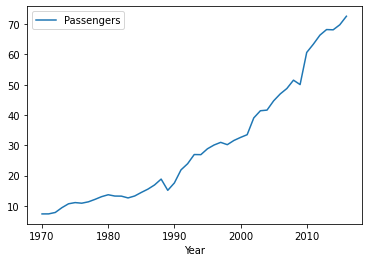

In [18]:
ausair.plot()

In [17]:
vals = ausair['Passengers'].values

In [19]:
vals[0]

7.32

In [51]:
alpha = 0.8

In [23]:
level1 = vals[0]

In [25]:
level2 = alpha * vals[1] + (1 - alpha) * level1

In [26]:
level2

7.329000000000001

In [27]:
vals[2]

7.8

In [29]:
level3 = alpha * vals[2] + (1 - alpha) * level2

In [30]:
vals.shape[0]

47

In [61]:
forecast = [vals[0]]
h = 10

for t in range(1, vals.shape[0] + h):
    value = vals[t] if t < vals.shape[0] else forecast[-1]
    forecast.append(alpha * value + (1 - alpha) * forecast[t-1])

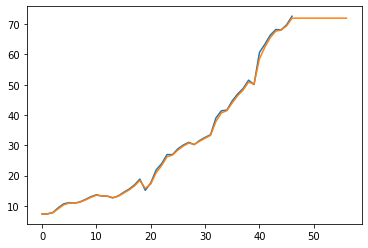

In [62]:
plt.plot(vals)
plt.plot(forecast)

In [87]:
alpha = 0.59
beta = 0.43
forecast = [vals[0]]
level = vals[0]
trend = vals[1] - vals[0]
h = 10

for t in range(1, vals.shape[0] + h):
    value = vals[t] if t < vals.shape[0] else forecast[-1]
    prev_level = level
    level = alpha * value + (1 - alpha) * (level + trend)
    trend = beta * (level - prev_level) + (1 - beta) * trend
    forecast.append(level + trend)

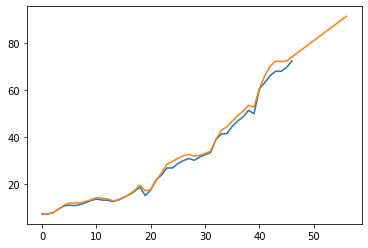

In [88]:
plt.plot(vals)
plt.plot(forecast)

In [85]:
alpha = 0.39
beta = 0.10
phi = 0.9
forecast = [vals[0]]
level = vals[0]
trend = vals[1] - vals[0]
h = 10

for t in range(1, vals.shape[0] + h):
    value = vals[t] if t < vals.shape[0] else forecast[-1]
    prev_level = level
    level = alpha * value + (1 - alpha) * (level + phi * trend)
    trend = beta * (level - prev_level) + (1 - beta) * phi * trend
    forecast.append(level + trend)

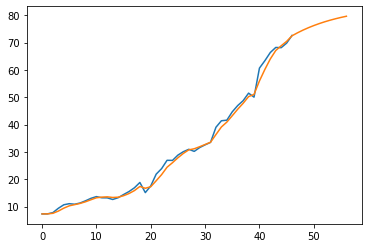

In [86]:
plt.plot(vals)
plt.plot(forecast)